In [2]:
from quantumsim import *

In [430]:
circuit = Circuit(4)
# Data qubit is 0, 1
# Ancillary qubit is 2 for detecting x errors, 3 for detecting z errors

# Create additional state

circuit.pauli_x(0)

circuit.cnot(0, 2)

circuit.hadamard(3)
circuit.pauli_z(1)
circuit.cnot(3, 1)
circuit.hadamard(3)



circuit.execute(print_state=False)
circuit.print_gates_and_descriptions()
circuit.measure(print_state=True)


X...	Pauli X on qubit 0
*.X.	CNOT with control qubit 0 and target qubit 2
...H	Hadamard on qubit 3
.Z..	Pauli Z on qubit 1
.X.*	CNOT with control qubit 3 and target qubit 1
...H	Hadamard on qubit 3
Measured state:
|1010>


'|1010>'

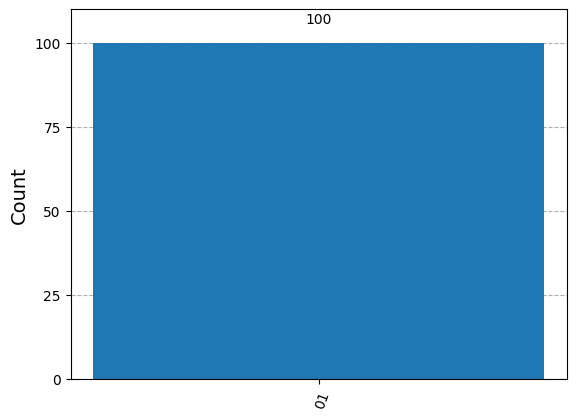

In [483]:
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram

# Create a new circuit with two qubits
qc = QuantumCircuit(2, 2)
 
# Add a Hadamard gate to qubit 0
# qc.z(0)
qc.x(0)
# qc.h(1)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
# qc.cx(1, 0)
# qc.h(1)

qc.measure(0, 0)
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

backend = BasicSimulator()

# If you do not specify the number of shots, the default is 1024
result = backend.run(qc, shots=100).result()   

# Extract the counts of 0 and 1 measurements
counts = result.get_counts()                    
plot_histogram(counts)


